### 8-ball shot

![alt text](image.png)

Conservation of momentum: $m_A {v_A}_i + m_B {v_B}_i = m_A {v_A}_f + m_B {v_B}_f$

Coefficient of restitution: $e = -\frac{{v_B}_f-{v_A}_f}{{v_B}_i-{v_A}_i}$

Conservation of energy: ${E_P}_i + {E_K}_i = {E_P}_f + {E_K}_f$

Mechanical kinetic energy: $E_{K_\text{mechanic}} = \frac{1}{2}mv^2$

In [751]:
%matplotlib widget
# Dependencies
import matplotlib.animation
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import patches

# Settings
plt.rcParams["animation.html"] = "jshtml"
plt.rcParams['figure.dpi'] = 150
w_ = 2.54
h_ = 1.27

In [752]:
class Ball(patches.Circle):
    def __init__(self, xy, ax, vel=[0,0], **kwargs):
        rad = 0.05715  # Fixed radius
        super().__init__(xy, rad, **kwargs)
        ax.add_patch(self)
        self.vel = np.array(vel).astype(np.float64)
        self.acc = np.zeros(2).astype(np.float64)
        
    def get_xy(self):
        return np.array(self.get_center()).astype(np.float64)

    def update(self, dti):
        pos = self.get_xy()
        if not np.linalg.vector_norm(self.vel) == 0:
            self.acc = - 0.6 * self.vel / np.linalg.vector_norm(self.vel)
        else:
            self.acc = np.zeros(2).astype(np.float64)
        self.vel += self.acc * dti
        if pos[0] + self.radius  > w_ or pos[0] - self.radius < 0:
            self.vel[0] *= -1
        if pos[1] + self.radius  > h_ or pos[1] - self.radius < 0:
            self.vel[1] *= -1
        pos += self.vel * dti
        self.set_center(pos)
        

In [753]:
""" YOUR CODE IN THIS BLOCK """

def estimate_cue_vel(pcb, p8b, phole):
    """ Estimate initial velocity of cue ball """
    vel = [5, 0]
    return vel

def collision(b_1, b_2):
    """ Check and apply collisions between b_1 and b_2 """
    p_b1 = b_1.get_xy()
    r_b1 = b_1.get_radius()
    v_b1 = b_1.vel
    p_b2 = b_2.get_xy()
    r_b2 = b_2.get_radius()
    v_b2 = b_2.vel

    b_1.vel = v_b1
    b_2.vel = v_b2


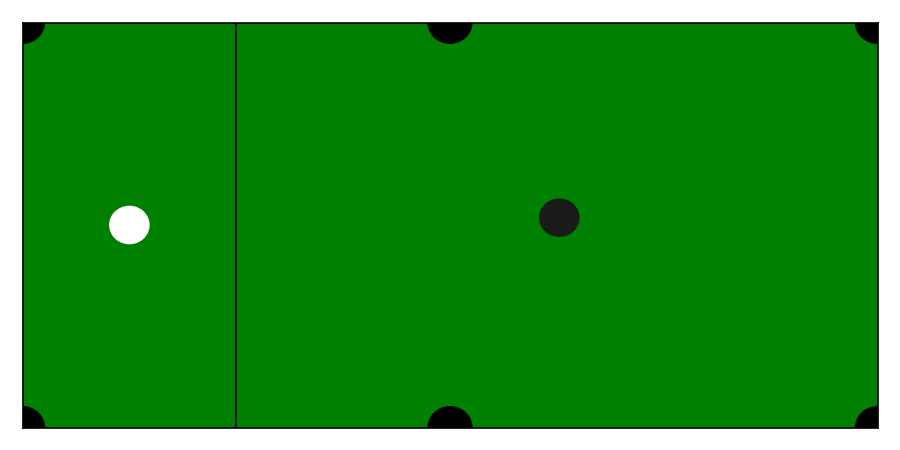

In [755]:
try:
    ani.event_source.stop()
except (NameError, AttributeError) as e:
    pass

# Plot setup
fig = plt.figure(figsize=(6,3))
fig.set_label("8 ball shot")
ax = fig.subplots()
ax.set_facecolor((0,0.5,0))
ax.set_xlim(0, w_)
ax.set_ylim(0, h_)
ax.set_xticks([])
ax.set_yticks([])

# Holes
ax.vlines(w_/4, 0, h_, 'k', linewidth=1, color=(.1,.1,.1), zorder=0)
p_holes = [[xi, yi] for yi in [0, h_] for xi in [0, w_/2, w_]]
for p_hi in p_holes:
    ax.add_patch(patches.Circle(p_hi, 0.064, color=(0,0,0)))

# Cue ball and 8 ball
p_cb = np.array([w_/8, h_/2])
p_8b = np.array([np.random.uniform(l_, s_-l_) for s_, l_ in zip([w_, h_], [w_/3, h_/8])])
p_hole = np.array(p_holes[np.random.choice(len(p_holes))])
v_cue = estimate_cue_vel(p_cb, p_8b, p_hole)
cue_b = Ball(p_cb, ax, vel=v_cue, color=(1,1,1))
eight = Ball(p_8b, ax, vel=[0,0], color=(.1,.1,.1))

# Time period
t_f = 10
t = np.linspace(0, t_f, num=t_f*200)
dt = np.diff(t)
dt = np.append(dt, [dt[-1]])

def update(dt_i):
    collision(cue_b, eight)
    cue_b.update(dt_i)
    eight.update(dt_i)

ani = matplotlib.animation.FuncAnimation(fig, update, frames=dt, interval=1000*np.mean(dt), repeat=False)
fig.tight_layout()
plt.show()
